# BNN with Variational Inference (VI) for predicting Band Gaps

In [1]:
import pyro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.distributions as dist

from pyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from tqdm.auto import trange

#from BNN_VI_model import BayesianNN
from BNN_VI_model_basic import BNN
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


### Load and preprocess the data 

In [2]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MP_Data_Corrected/mp_data_100k_cleaned2.csv')

In [3]:
df_mp = df_mp[(df_mp['band_gap'] > 0.2)]
y = df_mp['band_gap']

In [4]:
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites", 'HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element']
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

In [5]:
#Train tes split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Drop non-numeric / irrelevant fields
non_feature_cols = [
    "sites", "composition", "formula_pretty", "structure", "symmetry",
    "material_id", "HOMO_character", "HOMO_element", "LUMO_character", "LUMO_element"
]
df = df_mp.drop(columns=non_feature_cols, errors='ignore')
df = df.dropna(subset=["band_gap"])


df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)
# Save original indices
original_indices = np.arange(len(df))

# Split first — before scaling — and keep track of original indices
X_raw = df.drop(columns=["band_gap"])
y_raw = df["band_gap"]

X_train_raw, X_test_raw, y_train_raw, y_test_raw, idx_train, idx_test = train_test_split(
    X_raw, y_raw, original_indices, test_size=0.2, random_state=42
)


In [7]:
from sklearn.preprocessing import StandardScaler

# 1. Initialize scalers
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# 2. Scale inputs
X_train = scaler_x.fit_transform(X_train_raw)
X_test = scaler_x.transform(X_test_raw)

# 3. Scale targets (y)
y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).ravel()

# 4. Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


### Train the model

In [8]:
pyro.clear_param_store()

model = BNN(input_dim=X_train.shape[1], hid_dim=128, n_hid_layers=3, prior_scale=0.1)
guide = AutoDiagonalNormal(model)
optimizer = Adam({"lr": 1e-3})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_epochs = 3000
progress_bar = trange(num_epochs)

# Add before training loop
train_losses = []
val_losses = []

for epoch in progress_bar:
    train_loss = svi.step(X_train_tensor, y_train_tensor) / X_train_tensor.shape[0]
    val_loss = svi.evaluate_loss(X_test_tensor, y_test_tensor) / X_test_tensor.shape[0]
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    progress_bar.set_postfix(loss=f"{train_loss:.4f}", val_loss=f"{val_loss:.4f}")

for epoch in progress_bar:
    loss = svi.step(X_train_tensor, y_train_tensor)
    progress_bar.set_postfix(loss=f"{loss / X_train_tensor.shape[0]:.4f}")

  0%|          | 0/3000 [00:00<?, ?it/s]

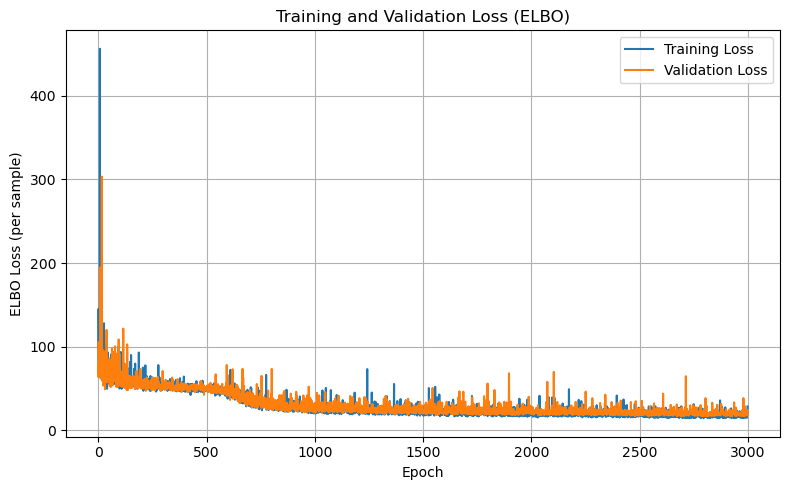

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("ELBO Loss (per sample)")
plt.legend()
plt.title("Training and Validation Loss (ELBO)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
predictive = Predictive(model, guide=guide, num_samples=500, return_sites=["obs"])
pred_samples = predictive(X_test_tensor)["obs"]  # shape: [500, num_test]
mean_pred = pred_samples.mean(dim=0).detach().numpy()
std_pred = pred_samples.std(dim=0).detach().numpy()

mean_pred_actual = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
std_pred_actual = std_pred * scaler_y.scale_[0]

y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

In [11]:
r2 = r2_score(y_test_actual, mean_pred_actual)
print(f"R² score: {r2:.4f}")

mse = mean_squared_error(y_test_actual, mean_pred_actual)
print("MSE:", mse)

R² score: 0.7624
MSE: 0.5196451926277386


In [12]:
# Sort by actual test values
sorted_indices = np.argsort(y_test_actual)
x = np.arange(len(y_test_actual))

# Sorted arrays
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
sorted_std_pred_actual = std_pred_actual[sorted_indices]

# Compute errors and find outliers
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]

# Map back to original indices to get formulas
outlier_test_indices = sorted_indices[outlier_indices]
outlier_original_indices = idx_test[outlier_test_indices]
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values


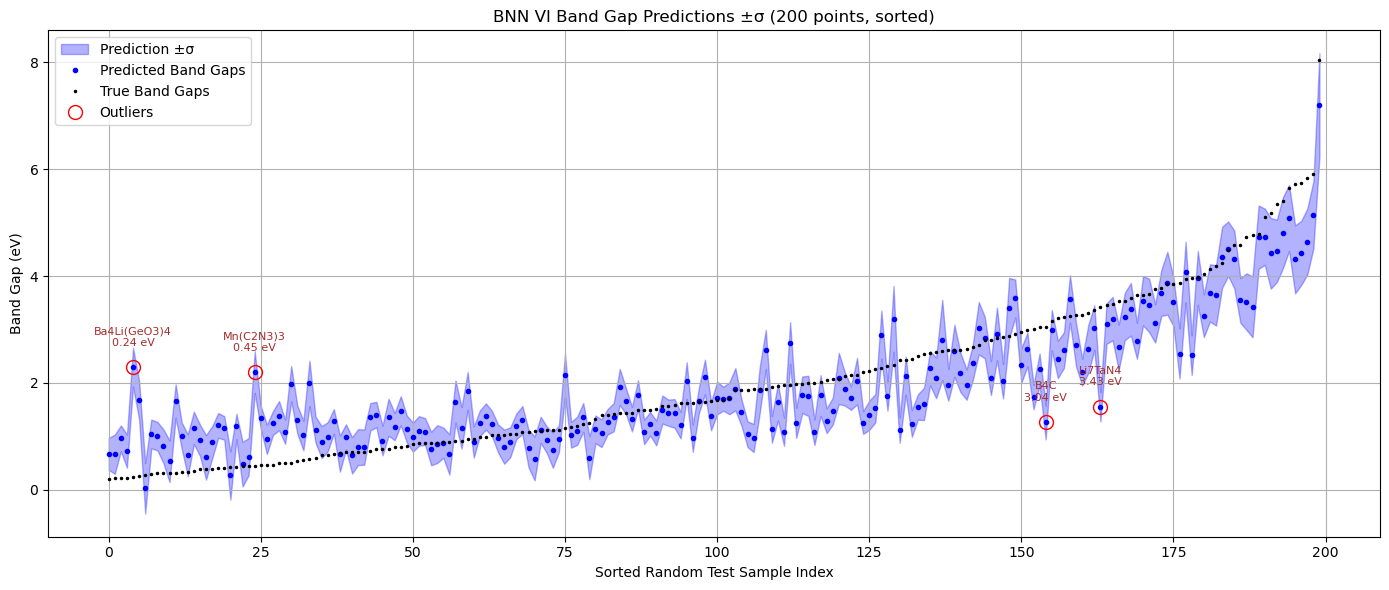

In [13]:

# Randomly select 200 unique indices from the test set
n_points = 200
total_points = len(mean_pred_actual)
np.random.seed(6)
rand_indices = np.random.choice(total_points, n_points, replace=False)

# Subset arrays
mean_sub = mean_pred_actual[rand_indices]
std_sub = std_pred_actual[rand_indices]
y_true_sub = y_test_actual[rand_indices]
test_indices_sub = rand_indices
formulas_sub = df_mp.iloc[idx_test[test_indices_sub]]["formula_pretty"].values

# Sort the subset by true band gap
sort_order = np.argsort(y_true_sub)
mean_sub = mean_sub[sort_order]
std_sub = std_sub[sort_order]
y_true_sub = y_true_sub[sort_order]
formulas_sub = formulas_sub[sort_order]

# Confidence interval
lower_sub = mean_sub - std_sub
upper_sub = mean_sub + std_sub

# Outlier detection
errors_sub = np.abs(mean_sub - y_true_sub)
outlier_mask_sub = errors_sub > 1.5
outlier_indices_sub = np.where(outlier_mask_sub)[0]

indices = np.arange(n_points)

plt.figure(figsize=(14, 6))
plt.fill_between(indices, lower_sub, upper_sub, alpha=0.3, label='Prediction ±σ', color='blue')
plt.plot(indices, mean_sub, 'o', markersize=3, label='Predicted Band Gaps', color='blue')
plt.plot(indices, y_true_sub, 'k.', markersize=3, label='True Band Gaps')
plt.plot(indices[outlier_indices_sub], mean_sub[outlier_mask_sub], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers (optional)
for i in outlier_indices_sub:
    plt.text(indices[i], mean_sub[i] + 0.4, f"{formulas_sub[i]}\n{y_true_sub[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

plt.xlabel("Sorted Random Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN VI Band Gap Predictions ±σ (200 points, sorted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Consistent plot for poster: 

In [29]:
def plot_uncertainty(
    x, y_true, y_pred, y_std, outlier_mask, formulas=None,
    title="Uncertainty Prediction (±σ)", file_name=None
):
    # Compute CI bounds
    lower = y_pred - y_std
    upper = y_pred + y_std

    # Compute metrics
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    # Outlier handling
    outlier_indices = np.where(outlier_mask)[0]
    outlier_preds = y_pred[outlier_indices]

    # Begin plot
    plt.figure(figsize=(14, 6))
    plt.fill_between(x, lower, upper, color='blue', alpha=0.3, label='Prediction ±σ')
    plt.plot(x, y_pred, 'o', markersize=3, color='blue', label='Predicted Band Gaps')
    plt.plot(x, y_true, 'k.', markersize=3, label='True Band Gaps')
    plt.scatter(x[outlier_indices], outlier_preds, edgecolor='black', facecolor='red', s=80, label='Outliers')

    # Annotate outliers (optional)
    if formulas is not None:
        for i, idx in enumerate(outlier_indices):
            plt.annotate(
                f"{formulas[i]}\n{y_true[idx]:.2f} eV",
                (x[idx], y_pred[idx]),
                textcoords="offset points",
                xytext=(0, 12),
                ha='center',
                fontsize=8,
                color='darkred'
            )

    plt.xlabel("Test Sample Index", fontsize=24)
    plt.ylabel("Band Gap (eV)", fontsize=24)
    #plt.title(f"{title}\nR²: {r2:.3f} | MSE: {mse:.3f}", fontsize=20)
    plt.legend(fontsize = 15)
    plt.grid(True)
    plt.tight_layout()


    if file_name:
        plt.savefig(file_name, dpi=300)
    else:
        plt.show()


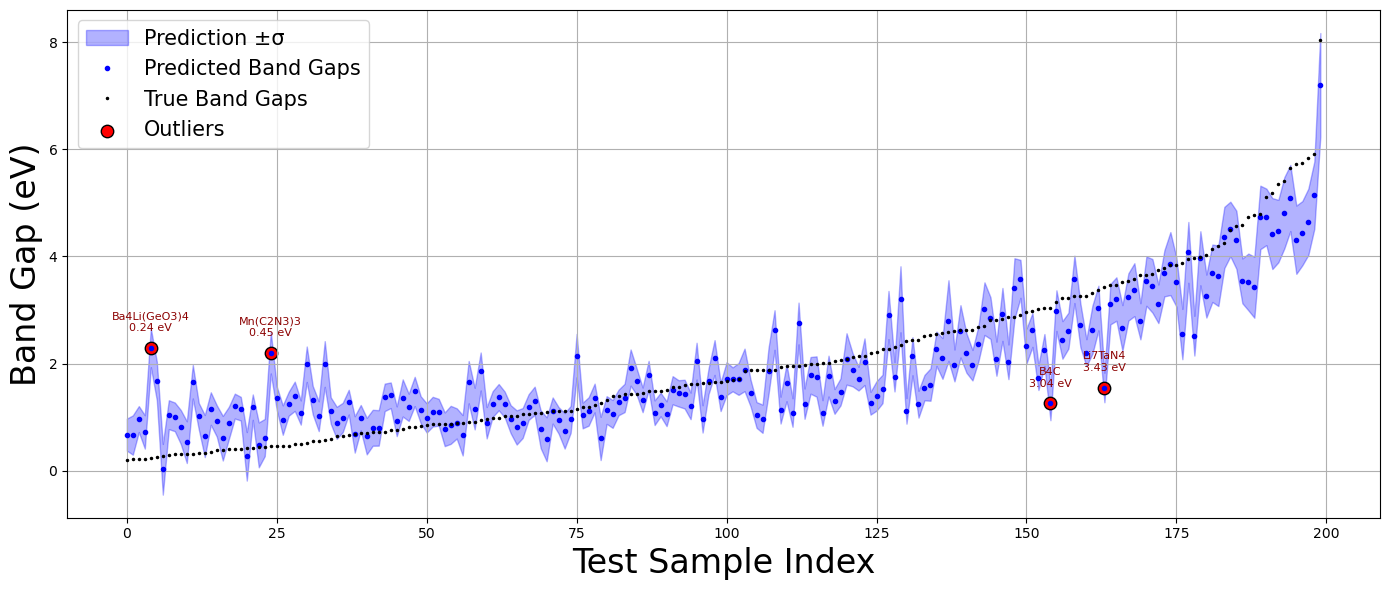

In [30]:
x = np.arange(200)
plot_uncertainty(
    x, y_true_sub, mean_sub, std_sub, outlier_mask_sub, 
    formulas=formulas_sub[outlier_indices_sub],
    title="BNN VI Band Gap Predictions (±σ)",
    #file_name="BNN_VI_BandGap.png"
)


### 95% CI

In [16]:
def plot_95ci(
    x, y_true, y_pred, y_std, outlier_mask, formulas=None,
    title="Prediction with 95% Confidence Interval", file_name=None
):
    # 95% CI bounds assuming normal distribution: ±1.96 * std
    ci_multiplier = 1.96
    lower = y_pred - ci_multiplier * y_std
    upper = y_pred + ci_multiplier * y_std

    # Compute metrics
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    # Outlier handling
    outlier_indices = np.where(outlier_mask)[0]
    outlier_preds = y_pred[outlier_indices]

    # Plot
    plt.figure(figsize=(14, 6))
    plt.fill_between(x, lower, upper, color='blue', alpha=0.3, label='95% Confidence Interval')
    plt.plot(x, y_pred, 'o', markersize=3, color='blue', label='Predicted Band Gaps')
    plt.plot(x, y_true, 'k.', markersize=3, label='True Band Gaps')
    plt.scatter(x[outlier_indices], outlier_preds, edgecolor='black', facecolor='red', s=80, label='Outliers')

    # Annotate outliers
    if formulas is not None:
        for i, idx in enumerate(outlier_indices):
            plt.annotate(
                f"{formulas[i]}\n{y_true[idx]:.2f} eV",
                (x[idx], y_pred[idx]),
                textcoords="offset points",
                xytext=(0, 12),
                ha='center',
                fontsize=8,
                color='darkred'
            )

    plt.xlabel("Test Sample Index")
    plt.ylabel("Band Gap (eV)")
    plt.title(f"{title}\nR²: {r2:.3f} | MSE: {mse:.3f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if file_name:
        plt.savefig(file_name, dpi=300)
    else:
        plt.show()


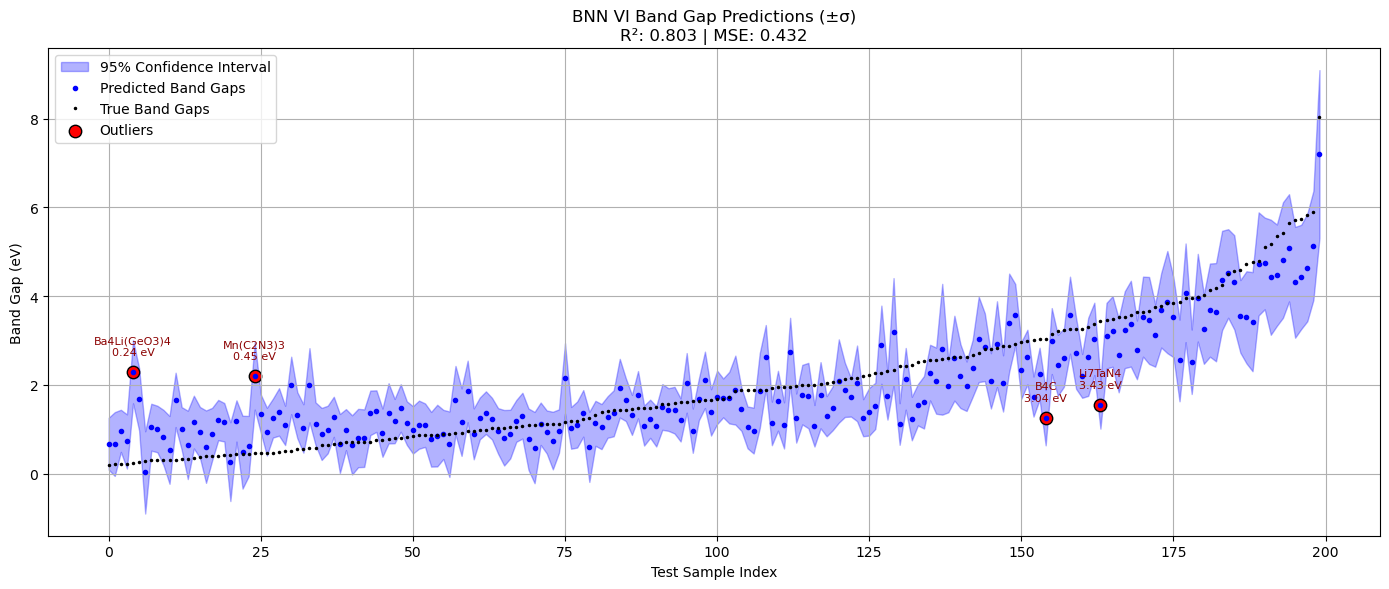

In [17]:
x = np.arange(200)
plot_95ci(
    x, y_true_sub, mean_sub, std_sub, outlier_mask_sub, 
    formulas=formulas_sub[outlier_indices_sub],
    title="BNN VI Band Gap Predictions (±σ)",
    #file_name="BNN_VI_BandGap.png"
)
